In [4]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydicom import dcmread
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../data/dicom/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [5]:
patients

['PAT001', 'PAT002', 'PAT003', 'PAT004', 'PAT034']

### Create slices and define thickness

In [34]:
path = '../data/dicom/' + patients[0]
slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
print(len(slices))
slices[0:2]

201


[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 208
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.5331506912231574009137053520150588438
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
 (0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
 -------------------------------------------------
 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELICAL']
 (0008, 0012) Instance Creation Date              DA: '0'
 (0008, 0013) Instance Creation Time              TM: '174444.875'
 (0008, 0016) SOP Class UID                       UI: CT I

The attribute `ImagePositionPatient` (0020,0032) is a decimal string that specifies the x, y, and z coordinates of the `upper left hand corner` (center of the first voxel transmitted) of the image, in millimeters. It is relative to an origin point called the `frame of reference`, which is a fixed point for a particular scanner. The frame of reference is identified by the `Frame of Reference UID` (0020,0052) attribute. **The coordinates are based on a right-handed patient-based coordinate system**, which means that the x-axis is increasing to the left side of the patient, the `y-axis` is increasing to the posterior side of the patient, and the `z-axis` is increasing toward the `head` of the patient1. This coordinate system is independent of the image orientation or slice location.

The `ImagePositionPatient` attribute is useful for determining the `spatial relationship` between different images or slices that share the same frame of reference. For example, you can calculate the distance between two slices by subtracting their `ImagePositionPatient` values and taking the norm of the resulting vector. You can also calculate the `slice thickness` by dividing the distance by the number of slices.

In [21]:
print(slices[0].ImagePositionPatient)
print(slices[0].ImagePositionPatient[2])
print(float(slices[0].ImagePositionPatient[2]))

[-120.799999, -158.5, -935.5]
-935.5
-935.5


In [35]:
slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

In [26]:
print(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])

-1.0


1.0

In [29]:
slices[0].SliceLocation, slices[1].SliceLocation

('933.5', '932.5')

In [32]:
cnt = 0
for s in slices:
    if s.SliceThickness != 1:
        cnt += 1
        
print(cnt)

0


In [14]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [33]:
for index in range(len(patients)):
    path = INPUT_FOLDER + patients[index]
    load_scan(path)
    print(f"Done {patients[index]}")

Done PAT001
Done PAT002
Done PAT003
Done PAT004
Done PAT034


### Get HU unit


In [37]:
slices[0].pixel_array.shape

(512, 512)

In [40]:
image = np.stack([s.pixel_array for s in slices])
image.shape

(201, 512, 512)

In [42]:
image = image.astype(np.int16)
type(image)

numpy.ndarray

In [44]:
slices[0].RescaleIntercept, slices[0].RescaleSlope

('-1024.0', '1.0')

In [45]:
cnt = 0
for num_slice in range(len(slices)):
    if slices[num_slice].RescaleSlope != 1:
        cnt += 1
print(cnt)

0


In [46]:
np.int16(slices[0].RescaleIntercept)

-1024

In [48]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)  # matrix sum/substraction operations
    
    return np.array(image, dtype=np.int16)

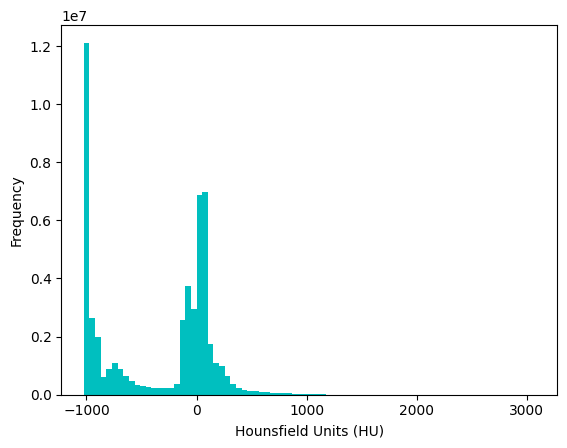

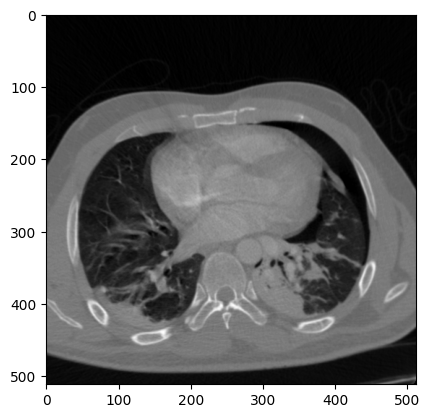

In [80]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle (80th slice in 201 slices in total)
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

### Resampling

In [78]:
# scan = slices
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [81]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (201, 512, 512)
Shape after resampling	 (201, 317, 317)


In [82]:
print(spacing)

[1.         1.00000058 1.00000058]


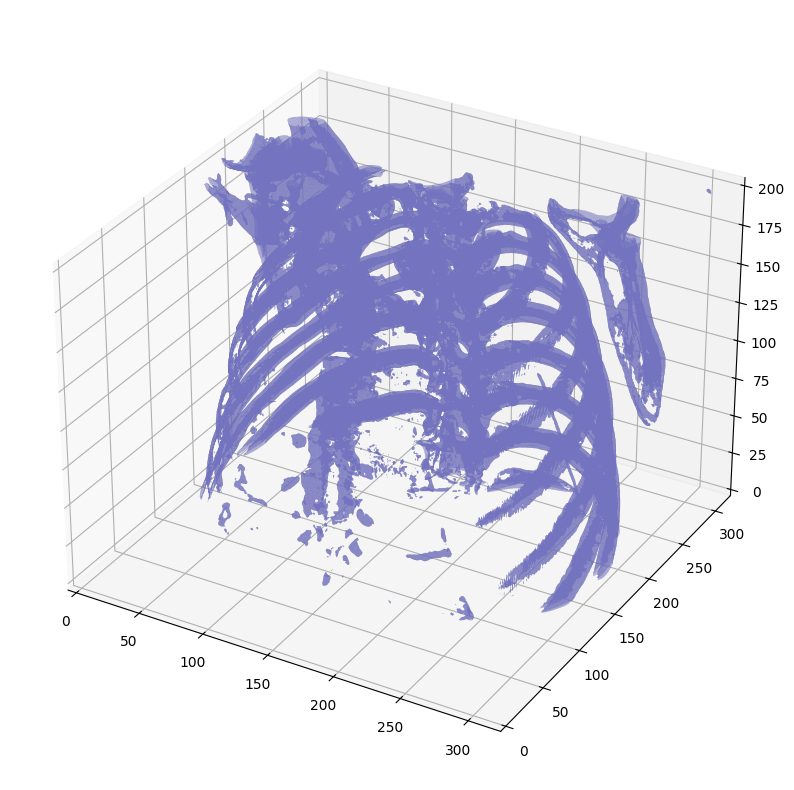

In [84]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(pix_resampled, 400)

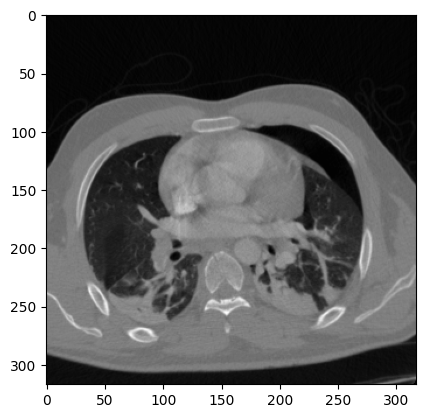

In [93]:
plt.imshow(pix_resampled[100], cmap=plt.cm.gray)

### Segmentation (For lung)

In [85]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    ''' not actually binary, but 1 and 2. 
    0 is treated as background, which we do not want '''
    binary_image = np.array(image > -320, dtype=np.int8) + 1
    labels = measure.label(binary_image)
    
    ''' Pick the pixel in the very corner to determine which label is air.
    Improvement: Pick multiple background labels from around the patient
    More resistant to "trays" on which the patient lays cutting the air 
    around the person in half'''
    
    background_label = labels[0,0,0]
    
    # Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: # This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 # Make the image actual binary
    binary_image = 1 - binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [86]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [90]:
segmented_lungs.shape

(201, 317, 317)

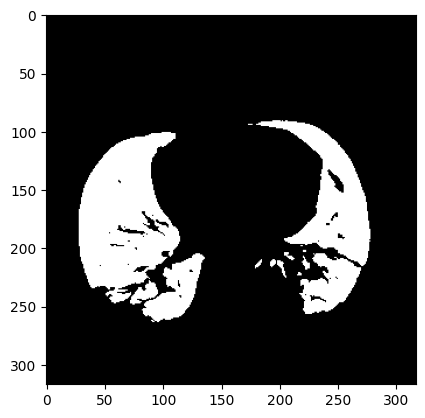

In [95]:
plt.imshow(segmented_lungs[80], cmap=plt.cm.gray)

In [97]:
from helpers import *

explore_3D_array(segmented_lungs)

interactive(children=(IntSlider(value=100, description='SLICE', max=200), Output()), _dom_classes=('widget-int…

In [98]:
explore_3D_array_comparison(
    arr_before=segmented_lungs,
    arr_after=pix_resampled,
    cmap='viridis'
)

interactive(children=(IntSlider(value=100, description='SLICE', max=200), Output()), _dom_classes=('widget-int…

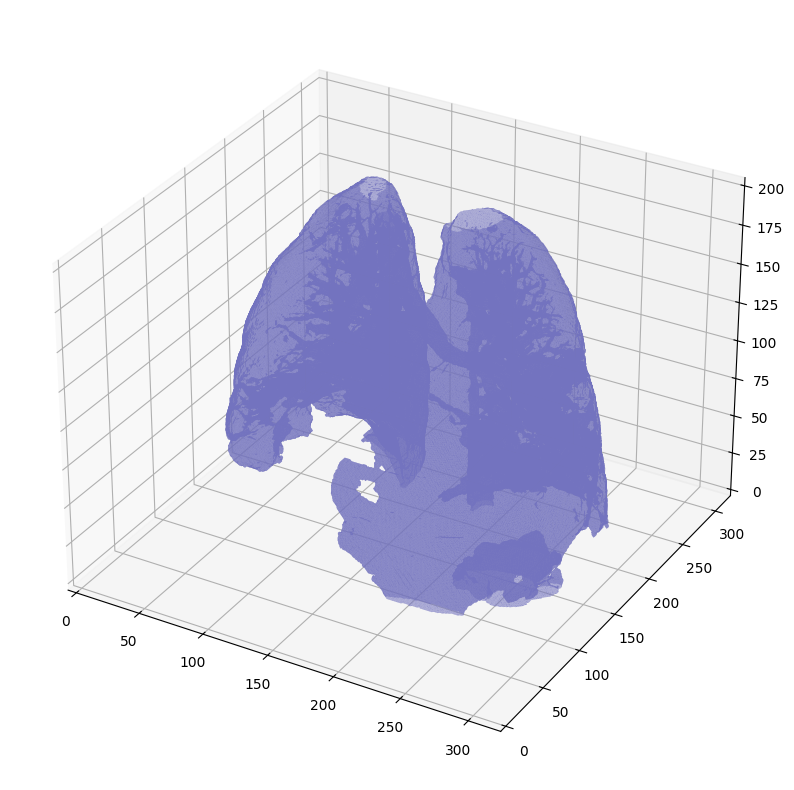

In [87]:
plot_3d(segmented_lungs, 0)

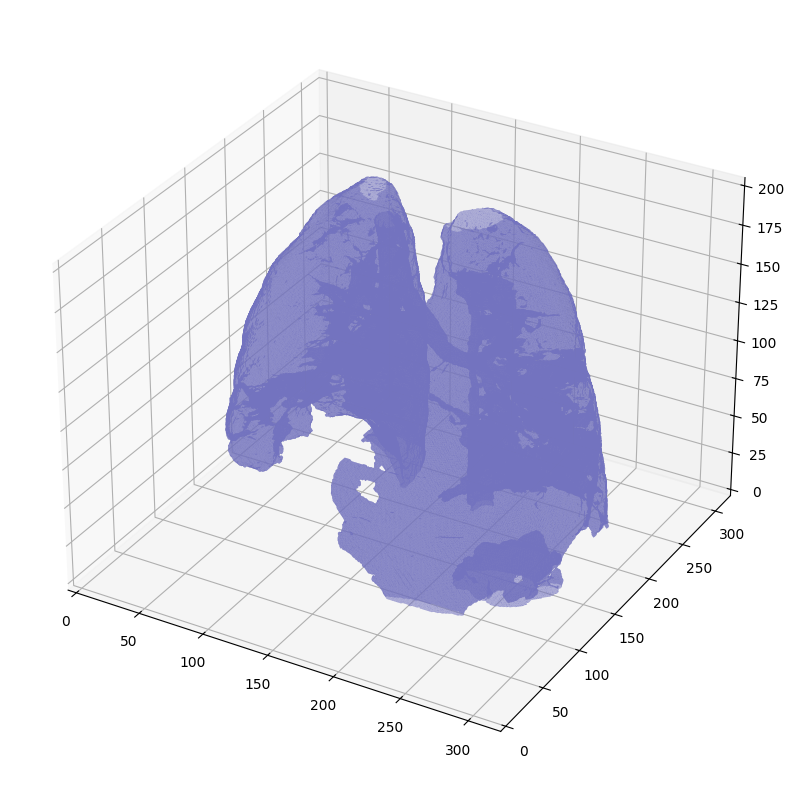

In [88]:
plot_3d(segmented_lungs_fill, 0)

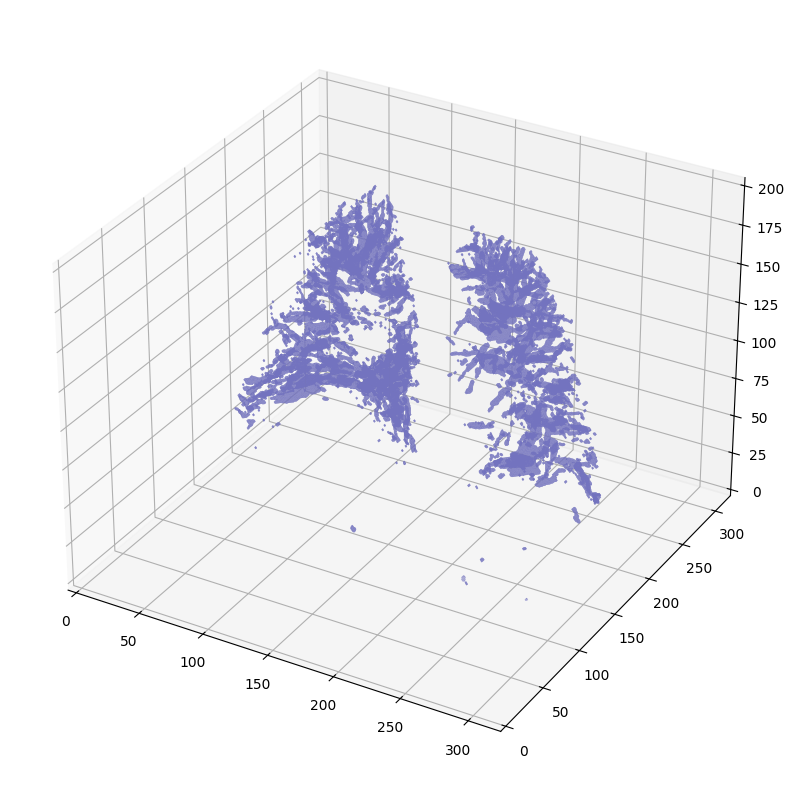

In [89]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)